In [79]:
#from langchain_community.embeddings.bedrock import BedrockEmbeddings

In [3]:
import os
import shutil
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema.document import Document
from langchain.vectorstores.chroma import Chroma
import hashlib
from langchain.prompts import ChatPromptTemplate
from langchain_community.llms.ollama import Ollama
from langchain_community.embeddings.ollama import OllamaEmbeddings
import random
from datasets import load_dataset
from langchain.schema import Document
import time
from evaluate import load
import evaluate



/Users/joudi/RAG_Effectiveness/RAG_Effectiveness/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ds = load_dataset("neural-bridge/rag-dataset-1200")

In [69]:

DATA_PATH = "/Users/joudi/Measuring_RAG_Effectiveness/data"

#CHROMA_PATH = "/Users/joudi/Measuring_RAG_Effectiveness/database"  
CHROMA_PATH = "/Users/joudi/Measuring_RAG_Effectiveness/"  

#os.makedirs(CHROMA_PATH)

def get_embedding_function():
    embeddings = OllamaEmbeddings(model="nomic-embed-text")
    return embeddings

In [70]:
def load_documents():
    document_loader = PyPDFDirectoryLoader(DATA_PATH)
    return document_loader.load()

def split_documents(documents):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,
        chunk_overlap=30,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

"""def calculate_chunk_ids(chunks):
    for chunk in chunks:
        source = chunk.metadata.get("source", "unknown_source")
        page = chunk.metadata.get("page", "unknown_page")
        content_hash = hashlib.md5(chunk.page_content.encode("utf-8")).hexdigest()
        
        # Create a unique ID using source, page, and a hash of the content
        chunk_id = f"{source}:{page}:{content_hash}"
        chunk.metadata["id"] = chunk_id

    return chunks"""

def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

def generate_unique_id(chunk):
    # Use current timestamp (in milliseconds) for uniqueness
    timestamp = str(int(time.time() * 1000))  # Current timestamp in milliseconds
    
    # Generate a random number to ensure uniqueness
    random_number = random.randint(100000, 999999)

    # use document content or metadata to make the ID more unique
    content_hash = hashlib.md5(chunk.page_content.encode('utf-8')).hexdigest()[:8]  # First 8 chars of MD5 hash
    
    # Create a unique ID combining the timestamp and content hash
    unique_id = f"{timestamp}_{content_hash}_{random_number}"
    
    return unique_id


"""def add_doc_to_chroma(chunks):
    db = Chroma(
        persist_directory=CHROMA_PATH,
        embedding_function=get_embedding_function()
    )
    chunks_with_ids = calculate_chunk_ids(chunks)

    existing_items = db.get(include=[])
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    new_chunks = [chunk for chunk in chunks_with_ids if chunk.metadata["id"] not in existing_ids]

    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
        if new_chunks:
            db.add_documents(new_chunks, ids=new_chunk_ids)
            db.persist()
        print("✅ Documents successfully added and persisted.")
    else:
        print("✅ No new documents to add")"""

def check_num_in_DB(path):
    try:
        # Load the existing database
        db = Chroma(persist_directory=path, embedding_function=get_embedding_function())
        existing_items = db.get(include=[])  # Fetch existing document metadata (IDs are always included)
        num_existing = len(existing_items["ids"])
        print(f"📊 Number of existing documents in DB: {num_existing}")
        return num_existing
    except Exception as e:
        print(f"❌ Error checking existing documents: {e}")
        return 0

#for context from DataSet
def get_context(ds):
    train_chunks = []
    test_chunks = []
    for context in ds["train"]["context"]:
        # Convert context string to Document object
        document = Document(page_content=context)
        # Split the document into smaller chunks
        chunked_documents = split_documents([document])
        # Add the chunked documents to the train_chunks list
        train_chunks.extend(chunked_documents)

    # Iterate over the test context data
    for context in ds["test"]["context"]:
        # Convert context string to Document object
        document = Document(page_content=context)
        # Split the document into smaller chunks
        chunked_documents = split_documents([document])
        # Add the chunked documents to the test_chunks list
        test_chunks.extend(chunked_documents)

    return train_chunks, test_chunks

def add_context_to_chroma(chunks):
    db = Chroma(
        persist_directory=CHROMA_PATH,
        embedding_function=get_embedding_function()
    )
    
    # Assign unique IDs to chunks
    for chunk in chunks:
        chunk.metadata["id"] = generate_unique_id(chunk)
    
    # Check if the number of new chunks is equal to the number of generated IDs
    # this is to extract the IDs we added and check if they already exist
    new_chunk_ids = [chunk.metadata["id"] for chunk in chunks]
    
    print(f"Number of chunks: {len(chunks)}")
    print(f"Number of chunk IDs: {len(new_chunk_ids)}")
    
    existing_items = db.get(include=[])
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # filter out duplicates to avoid failures :')
    new_chunks = [chunk for chunk in chunks if chunk.metadata["id"] not in existing_ids]

    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        batch_size = 5000
        for i in range(0, len(new_chunks), batch_size):
            batch = new_chunks[i:i + batch_size]
            batch_ids = [chunk.metadata["id"] for chunk in batch]
            print(f"Adding batch with {len(batch)} documents and {len(batch_ids)} IDs")
            db.add_documents(batch, ids=batch_ids)
            db.persist()
        print("✅ Documents successfully added and persisted.")
    else:
        print("✅ No new documents to add")

"""def add_context_to_chroma(chunks):
    db = Chroma(
            persist_directory=CHROMA_PATH,
            embedding_function=get_embedding_function()
        )
    #chunks_with_ids = calculate_chunk_ids(chunks)
    for chunk in chunks:
        chunk.metadata["id"] = generate_unique_id(chunk)  

    existing_items = db.get(include=[])
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    new_chunks = [chunk for chunk in chunks if chunk.metadata["id"] not in existing_ids]

    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        batch_size = 5000
        for i in range(0, len(new_chunks), batch_size):
            batch = new_chunks[i:i + batch_size]
            new_chunk_ids = [chunk.metadata["id"] for chunk in batch]
            db.add_documents(batch, ids=new_chunk_ids)
            db.persist()
        if new_chunks:
            db.add_documents(new_chunks, ids=new_chunk_ids)
            db.persist()
        print("✅ Documents successfully added and persisted.")
    else:
        print("✅ No new documents to add")"""




'def add_context_to_chroma(chunks):\n    db = Chroma(\n            persist_directory=CHROMA_PATH,\n            embedding_function=get_embedding_function()\n        )\n    #chunks_with_ids = calculate_chunk_ids(chunks)\n    for chunk in chunks:\n        chunk.metadata["id"] = generate_unique_id(chunk)  \n\n    existing_items = db.get(include=[])\n    existing_ids = set(existing_items["ids"])\n    print(f"Number of existing documents in DB: {len(existing_ids)}")\n\n    new_chunks = [chunk for chunk in chunks if chunk.metadata["id"] not in existing_ids]\n\n    if len(new_chunks):\n        print(f"👉 Adding new documents: {len(new_chunks)}")\n        batch_size = 5000\n        for i in range(0, len(new_chunks), batch_size):\n            batch = new_chunks[i:i + batch_size]\n            new_chunk_ids = [chunk.metadata["id"] for chunk in batch]\n            db.add_documents(batch, ids=new_chunk_ids)\n            db.persist()\n        if new_chunks:\n            db.add_documents(new_chunks, id

In [92]:
clear_database()

In [ ]:
#documents = load_documents()
#chunks = split_documents(documents)
#add_to_chroma(chunks)
#train_chunk, test_chunk = get_context(ds)
#add_context_to_chroma(train_chunk)
#add_context_to_chroma(test_chunk)
check_num_in_DB(CHROMA_PATH)



Number of chunks: 1450
Number of chunk IDs: 1450
Number of existing documents in DB: 5688
👉 Adding new documents: 1450
Adding batch with 1450 documents and 1450 IDs
✅ Documents successfully added and persisted.
📊 Number of existing documents in DB: 7138


7138

In [52]:

PROMPT_TEMPLATE = """
Use the context below to answer the question concisely. If the context is not sufficient, state that.

Context:
{context}

Question:
{question}
"""


In [7]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 960
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 240
    })
})


In [74]:
answers = []
n_questions = 20
random.seed(11)

# get the train answers provided from the dataset
for answer in ds["train"]["answer"]:
    answers.append(answer)

random.shuffle(answers)
answers = answers[:n_questions]
print(answers)

['The KI Work Environment and Health Award consists of a certificate and 30 000 SEK, to use for further joint activities in the workplace to promote health at work. The prize winner may be an employee/co-worker, a manager, a team, a workplace or a department/equivalent.', "The ideal spin serve will, if given the chance, bounce twice on the opponent's side of the table, with the second bounce as close to the endline as possible.", 'The different bat options mentioned are Player Edition, Signature, and Reserve.', "Some common problems that can damage a roof include the sun's UV rays causing deterioration, snow and ice causing leaks, strong gusts of wind tearing off shingles, overhanging tree limbs rubbing against the roof, birds and small wildlife creating holes, insects chewing at fascia boards and eaves, faulty flashing allowing water to seep in, clogged gutters causing water backup, poorly ventilated attics causing shingles to dry out and become brittle, and lack of roof maintenance l

In [75]:
n_questions = 20
random.seed(11)

# get the train questions from dataset
questions = []
for question in ds["train"]["question"]:
    questions.append(question)

    
random.shuffle(questions)
questions = questions[:n_questions]

print(questions)
answers_llama = []
answers_qwen = []


['What does the KI Work Environment and Health Award consist of and who can be nominated for it?', 'What is the ideal spin serve in table tennis?', 'What are the different bat options mentioned for the PlayersGrade cricket bat sticker design?', 'What are some common problems that can damage a roof?', "What was the reason for Gwendolyn Cuff's lawsuit against International Business Machine Company (IBM)?", 'Who inspired the Farmer family to consider adoption from China?', 'What is the consequence of a DUI in terms of car insurance according to Nevada laws?', 'What are some of the attractions and activities available in Salem, Massachusetts?', 'What does Sissyboy_D do with a vacuum cleaner in the video?', 'What are the controls for the game Stellar Interface?', 'What are some steps the NCUA has taken to encourage federally chartered credit unions?', 'What is the fundamental non-technical difference between Premiere Elements and Premiere Pro?', 'What are the benefits of L Glutamine as desc

In [76]:
for question in questions:
    answer_rag, context = query_rag(question)
    answers_llama.append({
        "question": question,
        "answer_rag": answer_rag, # check the model used
        "answer_without": query_without_context(question),
        "context": context
    })

In [80]:
for question in questions:
    answer_rag, context = query_rag(question)
    answers_qwen.append({
        "question": question,
        "answer_rag": answer_rag, # check the model used
        "answer_without": query_without_context(question),
        "context": context

    })

In [82]:
import csv

# Save answers_qwen to a CSV file for future review
with open('answers_qwen.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["question", "answer_rag", "answer_without", "context"])
    writer.writeheader()
    writer.writerows(answers_qwen)

# Save answers_qwen to a CSV file for future review
with open('answers_qwen_test.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["question", "answer_rag", "answer_without"])
    writer.writeheader()
    writer.writerows(answers_qwen_test)

In [77]:
with open('answers_llama.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["question", "answer_rag", "answer_without", "context"])
    writer.writeheader()
    writer.writerows(answers_llama)

with open('answers_llama_test.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["question", "answer_rag", "answer_without"])
    writer.writeheader()
    writer.writerows(answers_llama_test)

In [79]:
def query_rag(query_text: str):
    # get the DB.
    embedding_function = get_embedding_function()  
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Search the DB.
    results = db.similarity_search_with_score(query_text, k=5)

    # Build context text from the top results
    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    
    # Format the prompt using the context and the query
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)  
    prompt = prompt_template.format(context=context_text, question=query_text)

    # Generate the model's response
    #model = Ollama(model="llama3.2:latest")
    model = Ollama(model="qwen:1.8b")  
    response_text = model.invoke(prompt)

    # Get source document IDs
    sources = [doc.metadata.get("id", None) for doc, _score in results]
    
    # Format the response for output
    formatted_response = f"Response: {response_text}\nSources: {sources}"
    
    # Output the response
    #print(formatted_response)
    
    return response_text, context_text

def query_without_context(query_text: str):
    #model = Ollama(model="llama3.2:latest")
    model = Ollama(model="qwen:1.8b") 

    # Generate the response from the model, without sending any context
    response_text = model.invoke(query_text)

    return response_text

In [11]:
# using metrics for Evaluation
bertscore = load("bertscore")

In [30]:
# compare the answers of the model with RAG
predictions_qwen_rag = [entry["answer_rag"] for entry in answers_qwen]
results_qwen = bertscore.compute(predictions=predictions_qwen_rag, references=answers, lang="en")
print(f"Precision of Qwen model with context is: {results_qwen['precision']}")
print(f"Average precision of Qwen model with context is: {sum(results_qwen['precision']) / len(results_qwen['precision']):0.3f}")

Precision of Qwen model with context is: [0.8285099267959595, 0.8499962687492371, 0.7705177068710327, 0.845622181892395, 0.8056120276451111, 0.7852283716201782, 0.7942086458206177, 0.8307557106018066, 0.8317534923553467, 0.806027889251709, 0.8206638097763062, 0.7793591022491455, 0.8649715185165405, 0.9355557560920715, 0.8173287510871887, 0.829719603061676, 0.7926945686340332, 0.7574712038040161, 0.7954857349395752, 0.8515809178352356]
Average precision of Qwen model with context is: 0.820


In [31]:
# compare the answers of the model Llama with RAG
predictions_llama_rag = [entry["answer_rag"] for entry in answers_llama]
results_llama = bertscore.compute(predictions=predictions_llama_rag, references=answers, lang="en")
print(f"Precision of Llama model with context is: {results_llama['precision']}")
print(f"Average precision of Llama model with context is: {sum(results_llama['precision']) / len(results_llama['precision']):0.3f}")

Precision of Llama model with context is: [0.8579671382904053, 0.7815169095993042, 0.8120019435882568, 0.7957863807678223, 0.884261965751648, 0.8656924962997437, 0.8263412714004517, 0.7797498106956482, 0.8589804768562317, 0.8272422552108765, 0.8086303472518921, 0.7652955055236816, 0.837438702583313, 0.8595802187919617, 0.7835190892219543, 0.8305968642234802, 0.8292722702026367, 0.7986270189285278, 0.8563112020492554, 0.853237509727478]
Average precision of Llama model with context is: 0.826


In [32]:
# compare the answers of the Qwen _without_ RAG
predictions_qwen = [entry["answer_without"] for entry in answers_qwen]
results_qwen = bertscore.compute(predictions=predictions_qwen, references=answers, lang="en")
print(f"Precision of Qwen model without context is: {results_qwen['precision']}")
print(f"Average precision of Qwen model without context is: {sum(results_qwen['precision']) / len(results_qwen['precision']):0.3f}")

Precision of Qwen model without context is: [0.825782060623169, 0.8093596696853638, 0.8117802143096924, 0.8431107997894287, 0.8258489370346069, 0.8479394912719727, 0.8436204791069031, 0.832645058631897, 0.8574590086936951, 0.8032870888710022, 0.8134545683860779, 0.8138843774795532, 0.8410120010375977, 0.8866012692451477, 0.8397082686424255, 0.8159328699111938, 0.853897750377655, 0.8333093523979187, 0.8527597784996033, 0.8264411091804504]
Average precision of Qwen model without context is: 0.834


In [33]:
# compare the answers of the Llama _without_ RAG
predictions_llama = [entry["answer_without"] for entry in answers_llama]
results_llama = bertscore.compute(predictions=predictions_llama, references=answers, lang="en")
print(f"Precision of Llama model without context is: {results_llama['precision']}")
print(f"Average precision of Llama model without context is: {sum(results_llama['precision']) / len(results_llama['precision']):0.3f}")

Precision of Llama model without context is: [0.8343126177787781, 0.8416059613227844, 0.7805914282798767, 0.8608595728874207, 0.7548799514770508, 0.8405669927597046, 0.7790666818618774, 0.8278319239616394, 0.8153802752494812, 0.7961475253105164, 0.8211145401000977, 0.7652231454849243, 0.8434082269668579, 0.8717678785324097, 0.803914487361908, 0.8297935128211975, 0.8022599220275879, 0.8169444799423218, 0.8502309918403625, 0.7981246709823608]
Average precision of Llama model without context is: 0.817


-------------
# Apply on Test Dataset

In [8]:
n_questions = 20
random.seed(11)

# get the questions from Test dataset
questions_test = []
for question in ds["test"]["question"]:
    questions_test.append(question)

    
random.shuffle(questions_test)
questions_test = questions_test[:n_questions]

print(questions_test)
answers_llama_test = []
answers_qwen_test = []

['What was the business model of the Donald Trump Network?', "What role did the author's mother play in the lives of the two girls mentioned in the context?", 'What are some potential solutions for the Outlook Send Error?', 'Who is the mayor of Clinton seeking his eighth term?', 'Who was Jessie Foster living with in Las Vegas before her disappearance?', "What are some of Jesse Oliver's musical influences?", 'What was the difference in views between Public Protector Busisiwe Mkhwebane and her predecessor Thuli Madonsela on the terms of reference of the judicial commission of inquiry into state capture?', 'What are the pros and cons of playing Katarina in a game?', "What is the woman's preference in the context?", 'What are some of the uses for the mobile homes produced?', 'What is the function of the BK-channel blocker GAL021 in relation to opioid-induced respiratory depression?', 'Where did the culture of drag racing originate?', 'Who were the two top executives at Vice Media that were

In [15]:
for question in questions_test:
    answers_llama_test.append({
        "question": question,
        "answer_rag": query_rag(question), # check the model used
        "answer_without": query_without_context(question)
    })

In [18]:
for question in questions_test:
    answers_qwen_test.append({
        "question": question,
        "answer_rag": query_rag(question), # check the model used
        "answer_without": query_without_context(question)
    })

In [20]:
answers_test = []
n_questions = 20
random.seed(11)

# get the answers provided from the dataset
for answer in ds["test"]["answer"]:
    answers_test.append(answer)

random.shuffle(answers_test)
answers_test = answers_test[:n_questions]
print(answers_test)

['The Donald Trump Network sold both the network’s ‘name’ and supplements. There was compensation for referring new people to the network and also for selling supplements. New clients would get a urine test kit to collect a sample of their urine, which would be sent to a laboratory for analysis. Various supplements in different combinations were then prescribed and would be sent to the client or members of the network each month.', "The author's mother was the Guardian ad Litem for the two girls, assigned by the court system to look out for their best interests. She petitioned for their needs, gave opinions on their living arrangements, and established a positive and stable relationship with them.", "Some potential solutions for the Outlook Send Error include creating a new Outlook profile and re-adding your data files, removing your Outlook data files from your Account Settings -> Data files list and adding them back again, and disabling your anti-virus for the operation. If the error

In [84]:
# compare the Test DS answers of the model with RAG
predictions_qwen_rag_test = [entry["answer_rag"] for entry in answers_qwen_test]
results_qwen_test = bertscore.compute(predictions=predictions_qwen_rag_test, references=answers_test, lang="en")
print(f"Precision of Qwen model with context using test DS is: {results_qwen_test['precision']}")
average_qwen_result_rag = sum(results_qwen_test['precision']) / len(results_qwen_test['precision'])
print(f"Average precision of Qwen model with context using test DS is: {average_qwen_result_rag:0.3f}")

Precision of Qwen model with context using test DS is: [0.7707095742225647, 0.8602573275566101, 0.8458157777786255, 0.8468570113182068, 0.8512611985206604, 0.8327263593673706, 0.7890494465827942, 0.8119370937347412, 0.8579158782958984, 0.7438424229621887, 0.89805668592453, 0.8437221050262451, 0.9425426721572876, 0.8266360759735107, 0.8330429792404175, 0.8862369656562805, 0.8400332927703857, 0.8153977394104004, 0.8804709911346436, 0.8650380373001099]
Average precision of Qwen model with context using test DS is: 0.842


In [85]:
# compare the answers of the model Llama with RAG
predictions_llama_rag_test = [entry["answer_rag"] for entry in answers_llama_test]
results_llama_test = bertscore.compute(predictions=predictions_llama_rag_test, references=answers_test, lang="en")
print(f"Precision of Llama model with context is: {results_llama_test['precision']}")
average_llama_result_rag = sum(results_llama_test['precision']) / len(results_llama_test['precision'])
print(f"Average precision of Llama model with context is: {average_llama_result_rag:0.3f}")

Precision of Llama model with context is: [0.8896971940994263, 0.9132505059242249, 0.8579166531562805, 0.9927899837493896, 0.9439313411712646, 0.8285902738571167, 0.8887848854064941, 0.8703585267066956, 0.8441950678825378, 0.8317444920539856, 0.9285246133804321, 0.8445356488227844, 0.9482240676879883, 0.8733073472976685, 0.8327681422233582, 0.8435680270195007, 0.9697893261909485, 0.8459093570709229, 0.8999610543251038, 0.9609237313270569]
Average precision of Llama model with context is: 0.890


In [86]:
# compare the answers of the Qwen _without_ RAG
predictions_qwen = [entry["answer_without"] for entry in answers_qwen_test]
results_qwen = bertscore.compute(predictions=predictions_qwen, references=answers, lang="en")
#print(f"Precision of Qwen model without context is: {results_qwen['precision']}")
average_qwen_result = sum(results_qwen_test['precision']) / len(results_qwen_test['precision'])
print(f"Average precision of Qwen model without context is: {average_qwen_result:0.3f}")

Average precision of Qwen model without context is: 0.842


In [91]:
# compare the answers of the Llama _without_ RAG
predictions_llama = [entry["answer_without"] for entry in answers_llama_test]
results_llama = bertscore.compute(predictions=predictions_llama, references=answers, lang="en")
#print(f"Precision of Llama model without context is: {results_llama['precision']}")
average_llama_result = sum(results_llama_test['precision']) / len(results_llama_test['precision'])
print(f"Average precision of Llama model without context is: {sum(results_llama_test['precision']) / len(results_llama['precision']):0.3f}")

Average precision of Llama model without context is: 0.890


# Rouge

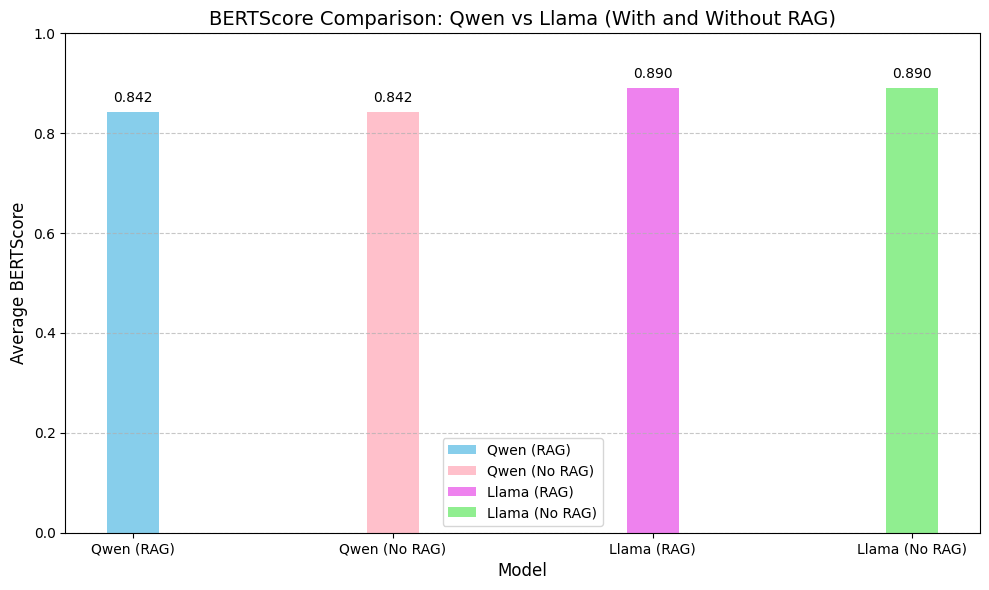

In [90]:
import matplotlib.pyplot as plt
import numpy as np

results = {
    "Qwen (RAG)": average_qwen_result_rag, 
    "Qwen (No RAG)": average_qwen_result, 
    "Llama (RAG)": average_llama_result_rag, 
    "Llama (No RAG)": average_llama_result
}
x = np.arange(4)
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['skyblue', 'pink', 'violet', 'lightgreen']
x_labels = list(results.keys())

for i, model in enumerate(x_labels):
    value = results[model]
    bar = ax.bar(x[i], value, width, label=model, color=colors[i])

    # Adding the value on top of each bar
    ax.text(
        x[i],
        value + 0.02,
        f'{value:.3f}', 
        ha='center',
        fontsize=10
    )
    
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Average BERTScore", fontsize=12)
ax.set_title("BERTScore Comparison: Qwen vs Llama (With and Without RAG)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_labels) 
ax.set_ylim(0, 1)
ax.legend()

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [44]:
accuracy_metric = evaluate.load("accuracy")

In [ ]:
results_accuracy = accuracy_metric.compute(references=answers, predictions=predictions_llama_rag)
print(results_accuracy)

ValueError: invalid literal for int() with base 10: 'The KI Work Environment and Health Award consists of a certificate and 30,000 SEK (Swedish Krona) to use for further joint activities in the workplace to promote health at work. The award is given to